In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://github.com/jeromerony/fast_adversarial.git

Cloning into 'fast_adversarial'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 84 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (84/84), 240.47 KiB | 4.08 MiB/s, done.


In [3]:
!pip install git+https://github.com/jeromerony/fast_adversarial

  Cloning https://github.com/jeromerony/fast_adversarial to /tmp/pip-req-build-nd05_3m1
  Running command git clone --filter=blob:none --quiet https://github.com/jeromerony/fast_adversarial /tmp/pip-req-build-nd05_3m1
  Resolved https://github.com/jeromerony/fast_adversarial to commit 45210b7c79e2deaeac9845d6c901dc2580d6e316
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for fast-adversarial: filename=fast_adversarial-0.1-py3-none-any.whl size=29326 sha256=a8f8657a353cb9bd342f77c8225519b8f51e54db126ec91e77c713979f6f3a35
  Stored in directory: /tmp/pip-ephem-wheel-cache-aj76vle5/wheels/d6/68/b8/b4ae3dd5ec7d260836ef6dbd54028

In [4]:
# Copy Files
!cp /content/drive/MyDrive/ML-Project/Test1.rar /content

In [8]:
! unrar x /content/Test1.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/Test1.rar

Extracting  ckpt.pth                                                       5% 10% 15% 20% 25% 31% 36% 41% 46% 51% 56% 62% 67% 72% 77% 82% 87% 93% 98% 99%  OK 
Extracting  resnet.py                                                     99%  OK 
All OK


In [9]:
!cp -r /content/resnet.py /content/fast_adversarial/fast_adv/models/cifar10

In [10]:
import argparse
import torch
import time
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn as nn
from fast_adv.attacks import DDN, CarliniWagnerL2
from fast_adv.utils import requires_grad_, l2_norm
import matplotlib.pyplot as plt
import os

from resnet import ResNet34

%matplotlib inline

torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_path = 'data/cifar10'  # Change this if you already downloaded MNIST elsewhere
model_url = ''
model_path = '/content/ckpt.pth'

In [11]:
!nvidia-smi

Wed Jul 12 19:02:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

100%|██████████| 170498071/170498071 [00:03<00:00, 49248321.43it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10


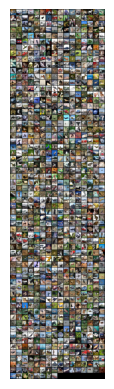

In [12]:
# Loading the data
transform_list = [transforms.ToTensor()]  #, transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_chain = transforms.Compose(transform_list)

dataset = datasets.CIFAR10(data_path, train=False,
                         transform=transform_chain,
                         download=True)
loader = data.DataLoader(dataset, shuffle=False, batch_size=1000)

x, y = next(iter(loader))
x = x.to(device)
y = y.to(device)

plt.imshow(make_grid(x.cpu(), nrow=16).permute(1,2,0))
plt.axis('off');

In [13]:
!git clone https://github.com/alirezaabdollahpour/ML_Graduate_Project_TA.git

Cloning into 'ML_Graduate_Project_TA'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 40 (delta 10), reused 29 (delta 7), pack-reused 0
Unpacking objects: 100% (40/40), 7.41 MiB | 9.68 MiB/s, done.


In [14]:
!cp /content/ML_Graduate_Project_TA/Phase_1/utils.py  /content/fast_adversarial/fast_adv/models/cifar10

In [15]:
%cd /content/fast_adversarial/fast_adv/models/cifar10
from utils import *

print('Loading model')

if not os.path.exists(model_path):
    import urllib
    print('Downloading model')
    urllib.request.urlretrieve(model_url, model_path)

# Inverse normalization
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)

# Move std and mean tensors to the same device as x
std = std.to(x.device)
mean = mean.to(x.device)

model = ResNet34()
model = nn.DataParallel(model)
loaded = torch.load(model_path)
model.load_state_dict(loaded['net'])
model = NormalizedModel(model, mean =  mean , std = std)
model.eval().to(device)
requires_grad_(model, False)

/content/fast_adversarial/fast_adv/models/cifar10
Loading model


Running DDN 100 attack


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Completed in 95.77s


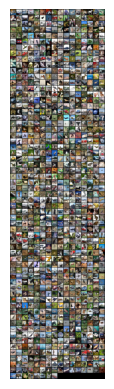

In [16]:
print('Running DDN 100 attack')
attacker = DDN(steps=100, device=device)
start = time.time()
ddn_atk = attacker.attack(model, x, labels=y, targeted=False)
ddn_time = time.time() - start
print('Completed in {:.2f}s'.format(ddn_time))

plt.imshow(make_grid(ddn_atk.cpu(), nrow=16).permute(1,2,0))
plt.axis('off');

In [17]:
pred_ddn = model(ddn_atk).argmax(dim=1).cpu()
print('DDN 100 done in {:.1f}s,   Success: {:.2f}%,   Mean L2: {:.4f},   Median L2: {:.4f}.'.format(
    ddn_time,
    (pred_ddn != y.cpu()).float().mean().item() * 100,
    l2_norm(ddn_atk - x).mean().item(),
    l2_norm(ddn_atk - x).median().item()
))
print()

DDN 100 done in 95.8s,   Success: 100.00%,   Mean L2: 0.1337,   Median L2: 0.1280.

